## Lesson 5 - Breast Cancer Detection
### Author: Ana Javed


### Instructions

It is recommended you complete the lab exercises for this lesson before beginning the assignment. (Data set source: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)) 

Using the WI_Breast_Cancer csv file, create a new notebook to build a decision tree classifier that would be able to detect whether a tumor is benign or malignant. Complete the following tasks and answer the questions:

1. Test both entropy and the gini coefficient. Which performs better and why?
2. What are the best hyperparameter settings for both?
3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?
4. Determine the AUC for the best model you can achieve. What are the precision and recal values and which might be the one you want to maximize?
5. What are the implications of using this type of machine learning algorithm for breast cancer analysis?



### Dataset Background

The Breast Cancer Wisconsin Data Set data were obtained from the University of Wisconsin Hospitals, Madison. Donors:

    Dr. William H. Wolberg, General Surgery Dept.
    W. Nick Street, Computer Sciences Dept.
    Olvi L. Mangasarian, Computer Sciences Dept.

They contain the simplified and normalized attributes used to detect breast cancer. 
Attributes:

    Sample code number: id number
    Class (4 for malignant, 2 for benign)
    Clump Thickness: 1 - 10
    Uniformity of Cell Size: 1 - 10
    Uniformity of Cell Shape: 1 - 10
    Marginal Adhesion: 1 - 10
    Single Epithelial Cell Size: 1 - 10
    Bare Nuclei: 1 - 10
    Bland Chromatin: 1 - 10
    Normal Nucleoli: 1 - 10
    Mitosis



In [369]:
## Importing Necessary Libraries & Packages 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime as dt
import csv
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Declaring inline visualizations 
%matplotlib inline


### Loading and Preprocessing the data

In [370]:
## Reading data file into Dataframe 
col_name_list = ["id","class","thickness","uniforming_size",
                 "uniformity_shape","adhesion","cell_size",
                 "nuclei","chromatic","nucleoli","mitosis"]

url = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/WI_Breast_Cancer.csv'
df = pd.read_csv(url, sep=",", header=None , names = col_name_list)

## Dropping an Erroneous row in the dataset
## df.loc[df.loc[:,"thickness"]== 1991.0, :]  # Exists on the 537 index 
df = df.drop(df.index[[537]])

## First 5 Rows from Dataframe
df.head()


,id,class,thickness,uniforming_size,uniformity_shape,adhesion,cell_size,nuclei,chromatic,nucleoli,mitosis
0,1000025,2,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1
1,1002945,2,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1
2,1015425,2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1
3,1016277,2,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1
4,1017023,2,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1


In [371]:
## Conducting Exploratory Data Analysis: 
print(df.shape)  # (709, 11)
print(df.dtypes) 
print(df.describe()) 


(708, 11)
id                   object
class                object
thickness           float64
uniforming_size     float64
uniformity_shape    float64
adhesion            float64
cell_size           float64
nuclei              float64
chromatic           float64
nucleoli            float64
mitosis              object
dtype: object
        thickness  uniforming_size  uniformity_shape    adhesion   cell_size  \
count  701.000000       701.000000         701.00000  701.000000  701.000000   
mean     4.433666         3.154066           3.21826    2.813124    3.226819   
std      2.827459         3.069053           2.97456    2.858201    2.220340   
min      1.000000         1.000000           1.00000    1.000000    1.000000   
25%      2.000000         1.000000           1.00000    1.000000    2.000000   
50%      4.000000         1.000000           1.00000    1.000000    2.000000   
75%      6.000000         5.000000           5.00000    4.000000    4.000000   
max     10.000000        10.

In [372]:
## Converting Mitosis column (currently Object) to Numeric
df["mitosis"] = pd.to_numeric(df.loc[:, "mitosis"], errors='coerce')
df["class"] = pd.to_numeric(df.loc[:, "class"], errors='coerce')

## Dropping rows with missing data. 8 rows removed 
df = df.dropna() 

print(df.shape)  # (700, 11)
print(df.dtypes) 
print(df.describe()) 


(700, 11)
id                   object
class               float64
thickness           float64
uniforming_size     float64
uniformity_shape    float64
adhesion            float64
cell_size           float64
nuclei              float64
chromatic           float64
nucleoli            float64
mitosis             float64
dtype: object
            class   thickness  uniforming_size  uniformity_shape    adhesion  \
count  700.000000  700.000000       700.000000        700.000000  700.000000   
mean     2.691429    4.425714         3.144286          3.212857    2.814286   
std      0.951881    2.821625         3.060297          2.973244    2.860079   
min      2.000000    1.000000         1.000000          1.000000    1.000000   
25%      2.000000    2.000000         1.000000          1.000000    1.000000   
50%      2.000000    4.000000         1.000000          1.000000    1.000000   
75%      4.000000    6.000000         5.000000          5.000000    4.000000   
max      4.000000   10.00000

In [373]:
## Dropping the ID Column since that's not an informative column
df = df.drop(columns = 'id')

## Changing the Values for class to be 0 and 1
df.loc[df.loc[:, "class"] == 4, 'class'] = 1  # malignant
df.loc[df.loc[:, "class"] == 2, 'class'] = 0  # benign 

print("Class Value Breakdown: ")
df.loc[:, "class"].value_counts()

Class Value Breakdown: 


0.0    458
1.0    242
Name: class, dtype: int64

### Separating Independent and Dependent Variables
Then separating Training/Testing Dataset 

In [374]:
independent_variables = list(df.columns)
independent_variables.remove("class")

print(independent_variables)

['thickness', 'uniforming_size', 'uniformity_shape', 'adhesion', 'cell_size', 'nuclei', 'chromatic', 'nucleoli', 'mitosis']


In [375]:
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split 

# Setting seed for reproducibility 
np.random.seed(123)

X = df.loc[:,independent_variables]  # Independent Variables 
Y = df.loc[:, "class"].astype(int)  # Dependent Variables 

## Standardizing / Normalizing Values with StandardScaler 
standardization_scale = StandardScaler().fit(X)
X = pd.DataFrame(standardization_scale.transform(X), 
                             columns=X.columns)

In [376]:
## Splitting Training and Testing Dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                    test_size = 0.25, random_state = 123)
print(y_train)

594    0
515    0
100    1
588    0
687    0
      ..
98     1
322    0
383    0
365    0
514    0
Name: class, Length: 525, dtype: int64


In [377]:
y_train.value_counts()

0    337
1    188
Name: class, dtype: int64

In [378]:
y_test.value_counts()

0    121
1     54
Name: class, dtype: int64

### Generate and Evaluate the Models 

In [379]:
from sklearn.tree import DecisionTreeClassifier 

# Model 1: Use entropy Criterion (with no hyperparameters)
model_ent = DecisionTreeClassifier(criterion='entropy', random_state = 1).fit(X_train, y_train) 
y_ent_pred = model_ent.predict(X_test)

# Model 2: Use Gini Criterion (default, with no hyperparameters)
model_gini = DecisionTreeClassifier(random_state = 1).fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_test)


### 1. Test both entropy and the gini coefficient. Which performs better and why?

In [380]:
# Generate an accuracy Score
from sklearn.metrics import accuracy_score

print("Entropy accuracy is : {}%".format(accuracy_score(
    y_test, y_ent_pred)*100))
print("Gini accuracy is : {}%".format(accuracy_score(
    y_test, y_gini_pred)*100))

Entropy accuracy is : 96.0%
Gini accuracy is : 95.42857142857143%


Here we can see that the Entropy accuracy is 1.6% higher than the Entropy accuracy. But let's see the breakdown by confusion matrix below...

In [381]:
print("Entropy Model Leaves: " ,model_ent.get_n_leaves())  #29
print("Entropy Model Depth: " ,model_ent.get_depth()) #11

print("Gini Model Leaves: " ,model_gini.get_n_leaves())  #33
print("Gini Model Depth: " ,model_gini.get_depth()) #10

Entropy Model Leaves:  29
Entropy Model Depth:  11
Gini Model Leaves:  33
Gini Model Depth:  10


In [382]:
from sklearn.metrics import confusion_matrix

print("Entropy Model Confusion Matrix: ")
print(pd.DataFrame(
    confusion_matrix(y_test, y_ent_pred),
    columns=['Predicted Benign', 'Predicted Malignant'],
    index=['True Benign', 'True Malignant']
))

print("\n")
print("Gini Model Confusion Matrix: ")
print(pd.DataFrame(
    confusion_matrix(y_test, y_gini_pred),
    columns=['Predicted Benign', 'Predicted Malignant'],
    index=['True Benign', 'True Malignant']
))

Entropy Model Confusion Matrix: 
                Predicted Benign  Predicted Malignant
True Benign                  119                    2
True Malignant                 5                   49


Gini Model Confusion Matrix: 
                Predicted Benign  Predicted Malignant
True Benign                  117                    4
True Malignant                 4                   50


Here we see that the Entropy model did slighty better at predicting true benign (2 more than the Gini model) and predicting true malignant (2 more than Gini model). This may be due to the Gini model creating more leaves (4 more) and 1 dept less than the Entrop model. 

### 2. What are the best hyperparameter settings for both?

In [383]:
# Entropy Model - with max depth set 
model_ent = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state = 1).fit(X_train, y_train) 
y_ent_pred = model_ent.predict(X_test)

# Gini model - with Min Samples Leaf set 
model_gini = DecisionTreeClassifier(min_samples_leaf=3, random_state = 1).fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_test)

In [384]:
# Generate an accuracy Score
from sklearn.metrics import accuracy_score

print("Entropy accuracy is : {}%".format(accuracy_score(
    y_test, y_ent_pred)*100))
print("Gini accuracy is : {}%".format(accuracy_score(
    y_test, y_gini_pred)*100))

Entropy accuracy is : 96.0%
Gini accuracy is : 96.57142857142857%


In [385]:
# Entropy Model - with Min Samples Leaf set 
model_ent = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3, random_state = 1).fit(X_train, y_train) 
y_ent_pred = model_ent.predict(X_test)

# Gini model - with max depth set  
model_gini = DecisionTreeClassifier(max_depth=4, random_state = 1).fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_test)

In [386]:
# Generate an accuracy Score
from sklearn.metrics import accuracy_score

print("Entropy accuracy is : {}%".format(accuracy_score(
    y_test, y_ent_pred)*100))
print("Gini accuracy is : {}%".format(accuracy_score(
    y_test, y_gini_pred)*100))

Entropy accuracy is : 97.14285714285714%
Gini accuracy is : 97.14285714285714%


In terms of hyperparameters, there was an increase when setting min_samples_leaf and max_depth for the models. When there was no hyperparameters used, then Entropy model was 96% accurate, where Gini accuracy was 95.42%.

When I set max_depth=4 for the models, the entropy model became 96.0% accurate and the Gini accuracy was 97.1%. This was an increase for only the Gini model. 

Next when I set min_samples_leaf=3 for both models, the entropy model was 97.1% accurate and the Gini accuracy was 96.5% accurate. This was an increase for both of the models. 

Based on these results, the entropy model benefitted most from having the min_samples_leaf parameter set (+1.1% increase), and the gini model benefitted most from the max_depth parameter (about 2% increase). 

### 3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?

[Text(462.7644230769231, 1037.7818181818182, 'thickness <= -0.211\nentropy = 0.941\nsamples = 525\nvalue = [337, 188]\nclass = class'),
 Text(107.3076923076923, 938.9454545454546, 'cell_size <= -0.264\nentropy = 0.189\nsamples = 311\nvalue = [302, 9]\nclass = class'),
 Text(53.65384615384615, 840.1090909090909, 'entropy = 0.0\nsamples = 284\nvalue = [284, 0]\nclass = class'),
 Text(160.96153846153845, 840.1090909090909, 'class <= -0.328\nentropy = 0.918\nsamples = 27\nvalue = [18, 9]\nclass = class'),
 Text(107.3076923076923, 741.2727272727273, 'entropy = 0.0\nsamples = 14\nvalue = [14, 0]\nclass = class'),
 Text(214.6153846153846, 741.2727272727273, 'nuclei <= -0.387\nentropy = 0.89\nsamples = 13\nvalue = [4, 9]\nclass = thickness'),
 Text(160.96153846153845, 642.4363636363637, 'entropy = 0.722\nsamples = 5\nvalue = [4, 1]\nclass = class'),
 Text(268.2692307692308, 642.4363636363637, 'entropy = 0.0\nsamples = 8\nvalue = [0, 8]\nclass = thickness'),
 Text(818.2211538461538, 938.9454545

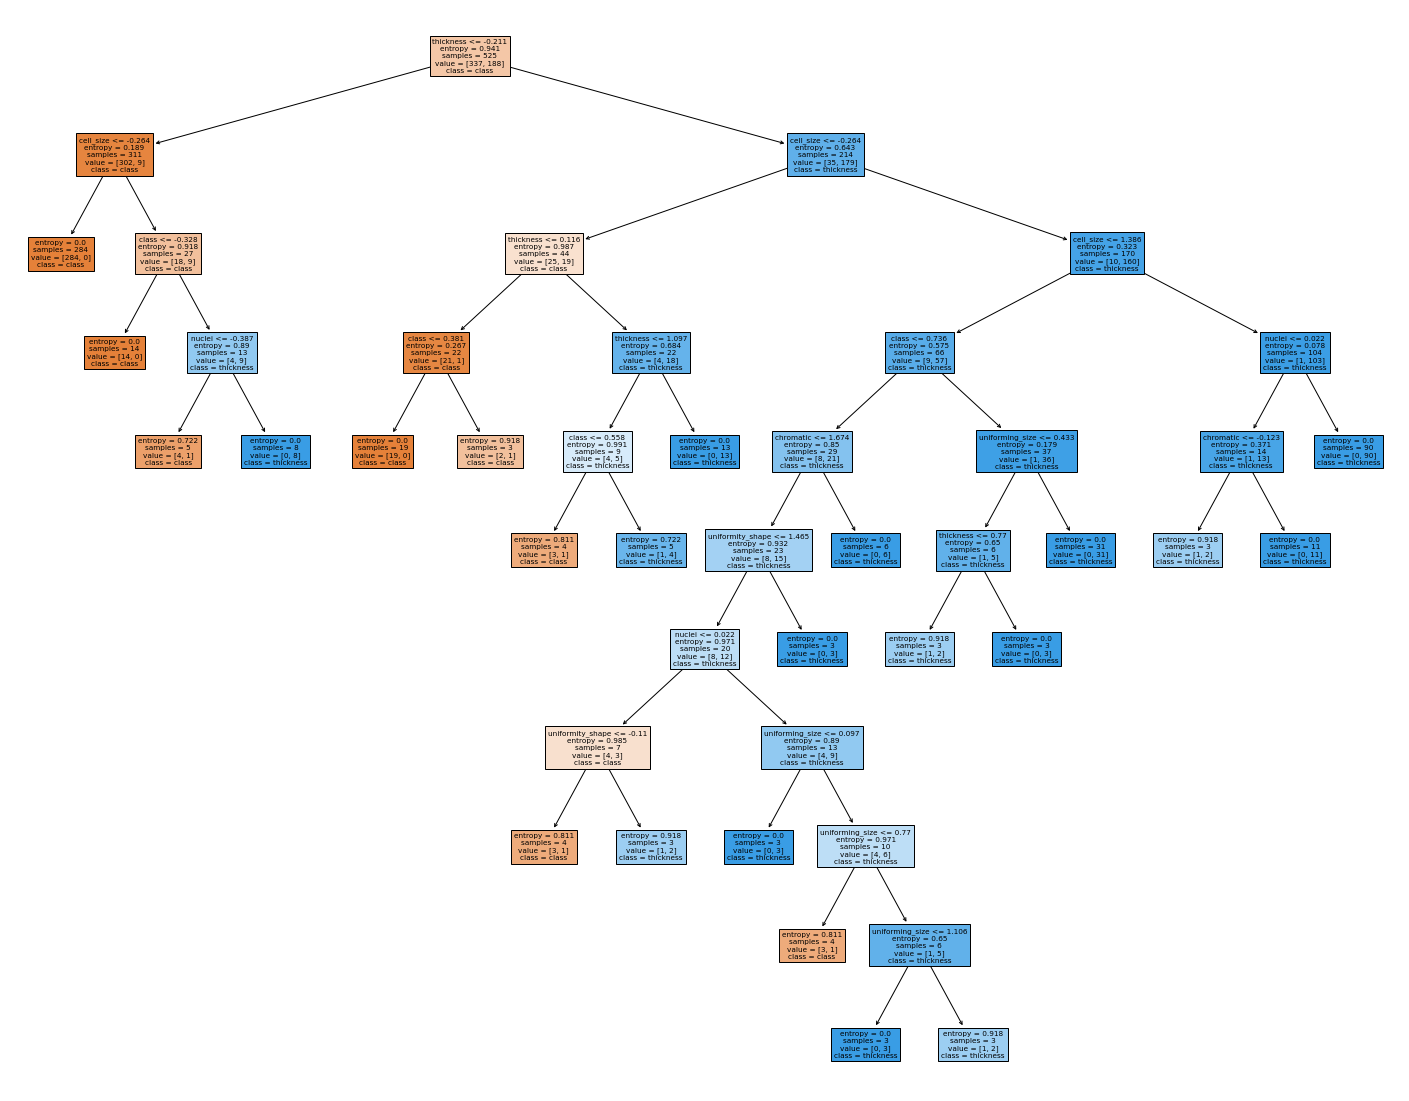

In [387]:
#create a visualization of the Entropy tree 
from sklearn import tree
import matplotlib.pyplot as plt

columns = list(df.columns)


fig = plt.figure(figsize=(25,20)) 
tree.plot_tree(model_ent,
                   feature_names=columns,  
                   class_names=columns,
                   filled=True)

[Text(610.3125, 978.48, 'thickness <= -0.211\ngini = 0.46\nsamples = 525\nvalue = [337, 188]\nclass = class'),
 Text(290.625, 761.0400000000001, 'cell_size <= 0.698\ngini = 0.056\nsamples = 311\nvalue = [302, 9]\nclass = class'),
 Text(174.375, 543.6, 'chromatic <= 2.0\ngini = 0.026\nsamples = 305\nvalue = [301, 4]\nclass = class'),
 Text(116.25, 326.1600000000001, 'class <= 0.736\ngini = 0.02\nsamples = 304\nvalue = [301, 3]\nclass = class'),
 Text(58.125, 108.72000000000003, 'gini = 0.007\nsamples = 300\nvalue = [299, 1]\nclass = class'),
 Text(174.375, 108.72000000000003, 'gini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = class'),
 Text(232.5, 326.1600000000001, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = thickness'),
 Text(406.875, 543.6, 'class <= -0.683\ngini = 0.278\nsamples = 6\nvalue = [1, 5]\nclass = thickness'),
 Text(348.75, 326.1600000000001, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = class'),
 Text(465.0, 326.1600000000001, 'gini = 0.0\nsamples = 5\nvalue = [0

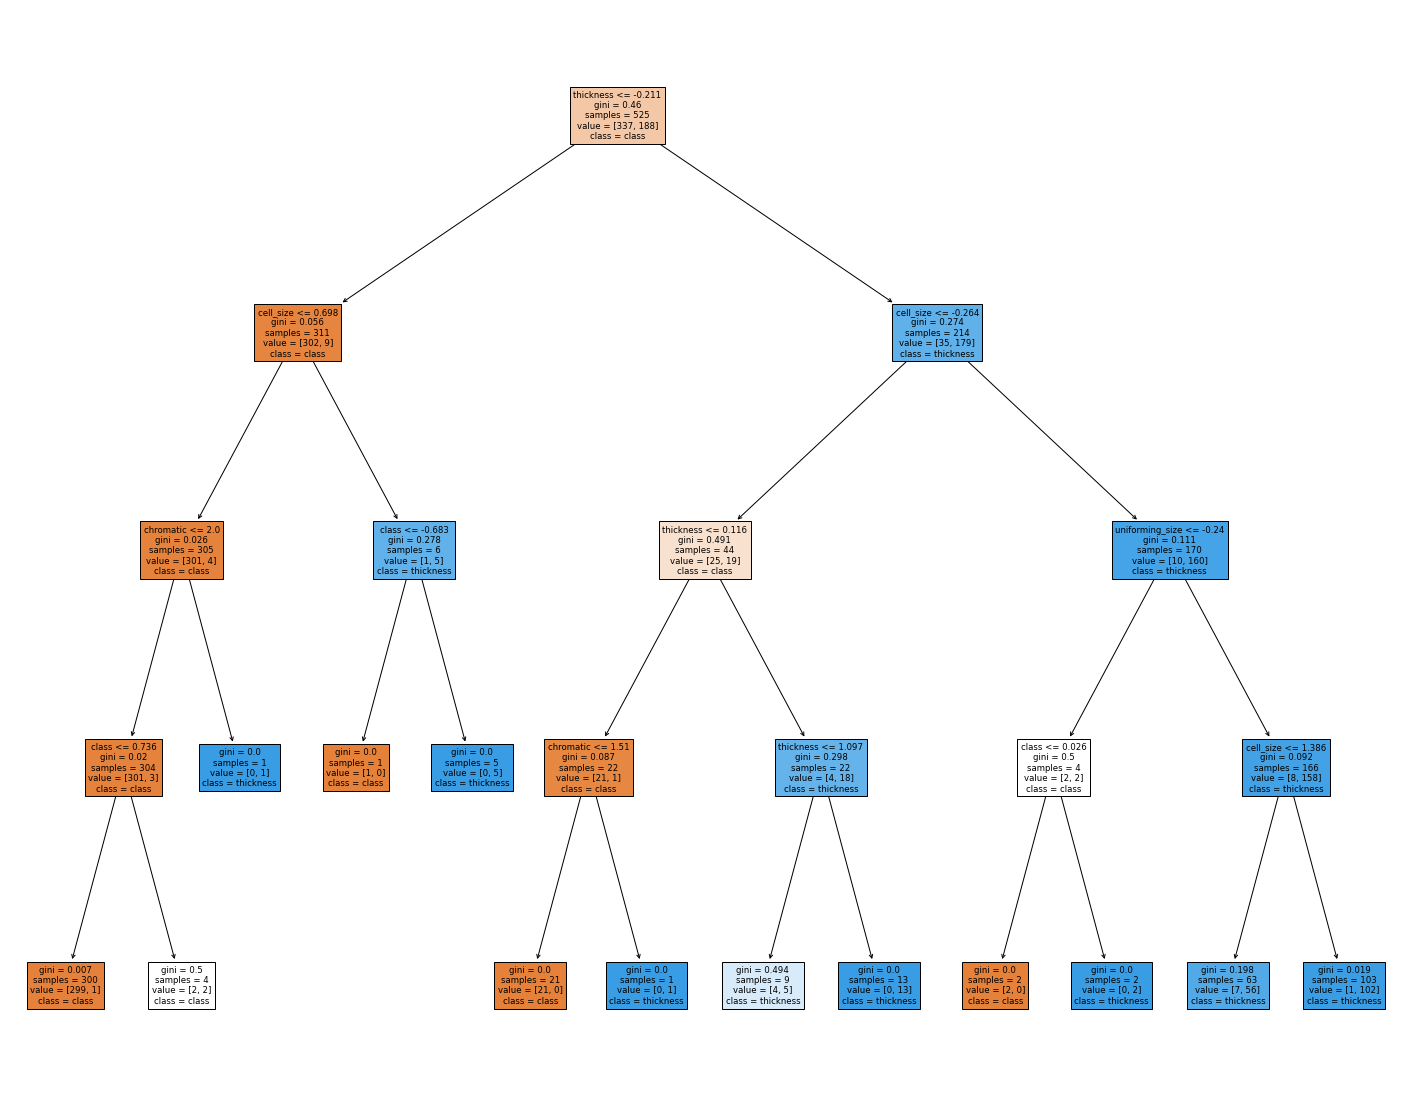

In [388]:
#create a visualization of the Gini tree 
from sklearn import tree
import matplotlib.pyplot as plt

columns = list(df.columns)


fig = plt.figure(figsize=(25,20)) 
tree.plot_tree(model_gini,
                   feature_names=columns,  
                   class_names=columns,
                   filled=True)

For the Entropy tree model, thickness was the top attribute. Then was cell size, and then nuclei. There appears to be 9 nodes or splits in this diagram.
For the Gini tree model, thickness was also the top attribute. Then was cell size, and then chromatic. These top attributes are similar, but ultimately different than the entropy model. Then 3rd top attribute for entropy was "nuclei" and for gini model it was "chromatic". This is due to entropy (information gain) and gini impurity being calculated different for the features. Ultimately each model chose a different 3rd most important variable.

### 4. Determine the AUC for the best model you can achieve. What are the precision and recal values and which might be the one you want to maximize?


In [389]:
## Computing Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
## from prediction scores.

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("AUC Score: ")
print("Entropy Model: ", roc_auc_score(y_test, y_ent_pred)*100)
print("Gini Model: ", roc_auc_score(y_test, y_gini_pred)*100)
print("\n")
print("Precision Score: ")
print("Entropy Model: ", precision_score(y_test, y_ent_pred)*100)
print("Gini Model: ", precision_score(y_test, y_gini_pred)*100)
print("\n")
print("Recall Score: ")
print("Entropy Model: ", recall_score(y_test, y_ent_pred)*100)
print("Gini Model: ", recall_score(y_test, y_gini_pred)*100)

AUC Score: 
Entropy Model:  95.88307315580043
Gini Model:  97.4211815120906


Precision Score: 
Entropy Model:  98.0392156862745
Gini Model:  92.98245614035088


Recall Score: 
Entropy Model:  92.5925925925926
Gini Model:  98.14814814814815


In [390]:
print("Entropy Model Confusion Matrix: ")
print(pd.DataFrame(
    confusion_matrix(y_test, y_ent_pred),
    columns=['Predicted Benign', 'Predicted Malignant'],
    index=['True Benign', 'True Malignant']
))

print("\n")
print("Gini Model Confusion Matrix: ")
print(pd.DataFrame(
    confusion_matrix(y_test, y_gini_pred),
    columns=['Predicted Benign', 'Predicted Malignant'],
    index=['True Benign', 'True Malignant']
))

Entropy Model Confusion Matrix: 
                Predicted Benign  Predicted Malignant
True Benign                  120                    1
True Malignant                 4                   50


Gini Model Confusion Matrix: 
                Predicted Benign  Predicted Malignant
True Benign                  117                    4
True Malignant                 1                   53


The AUC score for Entropy model is 95.9% whereas it is higher and sits at 97.42% for the Gini model. The precision score for the Entropy model is 98.03% whereas it is lower at 92.98% for the Gini model. Lastly the recall score for the entropy model is 92.59% which is lower than the gini model which is at 98.15%. 

Since this is a Breast Cancer detection dataset, you don't want to have a high amount of false negatives (or true cases that go undetected). The Gini model produced less false negatives than the Entropy model, and also had a higher recall ratio (tp / (tp + fn) which is what we want to maximize for Breast Cancer detection.

### 5. What are the implications of using this type of machine learning algorithm for breast cancer analysis?

There are a lot of implications of this machine learning algorithm for breast cancer analysis. As mentioned above, we want to limit as much as false negatives as possible. This is because if someone has breast cancer we don't want any risk of it being under detected, and having patients die especially if it could have been caught. Another thing to consider is the demographics of a patient - which were not part of this dataset. There are other indicators and risk factors for someone to develop breast cancer, and those factors should be considered and included as well.

Lastly, and most importantly, the machine learning algorithm cannot be the sole detector of breast cancer for a patient. A doctor should be notified if a model identifies a patient of possibly having cancer, and additional diagnostic and blood work should be conducted to confirm or deny the results. Since cancer has no cure, it's vital to have a physicians involvement in this diagnosis process.